In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec
import numpy as np
import cv2
import os
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 17}

plt.rc('font', **font)

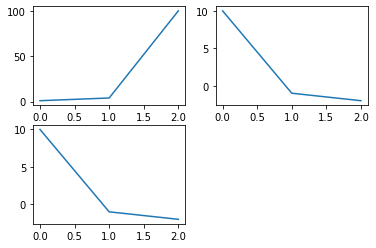

In [2]:
class DynamicFig:

    def __init__(self, figure=None, cols=1) -> None:
        """Constructs a DrawExample for one column and multiple rows.

        Note that subplots are added to the bottom.
        """
        self.cols = cols
        if figure is None:
            self.fig = plt.figure(facecolor='white')
        else:
            self.fig = figure
        self.images = 0
        
    def plot_image(self, image):
        def draw_image(ax):
            if len(image.shape) == 2:
                ax.imshow(image, cmap='Greys')
            else:
                ax.imshow(image)

            return ax
            
        return self.plot_bottom(draw_image)
        
        
            
    def plot_data(self, data):
        def draw_data(ax):
            ax.plot(data)
            return ax
        return self.plot_bottom(draw_data)
        
    def plot_bottom(self, fn):
        # """Plots the data to a new subplot at the bottom."""
       
        self.images += 1
        nrows = self.images // self.cols + 1
        gs = gridspec.GridSpec(nrows=nrows, ncols=self.cols)

        n = len(self.fig.axes)
        for i in range(n):
            self.fig.axes[i].change_geometry(nrows, self.cols, i+1)

        # Add the new
        new_ax = self.fig.add_subplot(nrows, self.cols, n+1)
        return fn(new_ax)
        # ax.plot([4,5,6])

        # plt.show() 

    def show(self) -> None:
        plt.show()
draw = DynamicFig(cols=2)
draw.plot_data([1, 4, 100])
draw.plot_data([10, -1, -2])
draw.plot_data([10, -1, -2])
draw.show()

In [3]:
a = np.array([34,2,3,22,22,22,22,22,22,18,90,5,-55,-19,22,6,6,6,6,6,6,6,6,23,53,1,5,-42,82])
b = np.array([
              [34,2,140,140,5,22,22,5,22,22,22,22,22,22,5,22,22,5,22,22],
              [34,2,22,22,5,22,22,5,22,22,22,22,22,22,5,22,22,5,22,22],
              [34,2,22,22,5,22,22,5,22,22,22,22,22,22,5,22,22,5,22,22],
              [34,2,22,22,5,22,22,5,22,22,22,22,22,22,5,22,22,5,22,22],
              [34,2,22,22,5,22,22,5,22,22,22,22,22,22,5,22,22,5,22,22],
              ])
is_white = 145
# image = b
def find_raw_pattern(image):
    # 2d 1c image\

    mat = image < is_white
    def zero_runs(row):
        iszero = np.concatenate(([0], np.equal(row, 0).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        return ranges

    def get_windows(row):
        res = zero_runs(np.diff(row))
        values = np.take_along_axis(row, res.T[0], axis = 0)
        values = values.reshape(values.shape[0], 1)
        return np.concatenate((res, values), axis=1)
    windows_rows = []
    windows_cols = []
    for row in mat:
        windows_rows.append(get_windows(row))
    for col in mat.T:
        windows_cols.append(get_windows(col))
    return windows_rows, windows_cols

In [4]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result


In [5]:

def get_pattern(image):
    windows_rows, windows_cols = find_raw_pattern(image)
    permissible_error = 0.1
    def check(s1, s2, s3, s4, s5):
        tasks = [
                 (s1, s2, 1),
                 (s1, s4, 1),
                 (s1, s5, 1),
                 (s1, s3, 3),
                 ]
        check = True
        for a, b, coef in tasks:
            check = check and (a[1] - a[0] + 1) * coef < (b[1] - b[0] + 1) * (1 + permissible_error) 
            check = check and (a[1] - a[0] + 1) * coef > (b[1] - b[0] + 1) * (1 - permissible_error)
        check = check and s3[2] == 1  # check center is black


        return check 
    def get_boxes(image, windows, is_transposed=False):
        res = []
        def is_symetric(col):
            bad_pixels = np.sum((col[:len(col)//2  + len(col)%2 + 1] > is_white) & (col[len(col)//2::-1] > is_white))
            return bad_pixels < len(col) / 4.

        for row_num, row in enumerate(windows):
            for win in window(row, n=5):
                s1, s2, s3, s4, s5 = win
                r = int((s5[1] - s1[0]) / 2.)
                x_center = int(np.average([s3[0],s3[1]]))
                if check(s1, s2, s3, s4, s5) and is_symetric(image[row_num - r:row_num + r,x_center]):

                    if is_transposed:
                        rec = (row_num - r, s1[0], row_num + r, s5[1])
                    else:
                        rec = (s1[0], row_num - r, s5[1], row_num + r)
                    res.append((row_num, s3, rec))
        return res
    res = get_boxes(image, windows_rows)
    res_cols_boxes = get_boxes(image.T, windows_cols, is_transposed=True)
    res = res + res_cols_boxes
    print(f'Pattern {res}')

    return res

In [6]:
def NMS(boxes, overlapThresh = 0.4):
    # Return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # Compute the area of the bounding boxes and sort the bounding
    # Boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We add 1, because the pixel at the start as well as at the end counts
    # The indices of all boxes at start. We will redundant indices one by one.
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        # Create temporary indices  
        temp_indices = indices[indices!=i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        # Find out the width and the height of the intersection box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index  
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    #return only the boxes at the remaining indices
    return boxes[indices].astype(int)

In [7]:
!ls /content/drive/MyDrive/Фивт/CV/Task6


TestSet1  TestSet2  TestSet3


## Download Data

In [8]:
path_to_data = {
    'test1' : './TestSet1',
    'test2' : './TestSet2',
    'test3' : './TestSet3',
}
google_drive_path = '/content/drive/MyDrive/Фивт/CV/Task6'
path_to_data = {key: os.path.join(google_drive_path, value) 
                for key, value in path_to_data.items()}
print(path_to_data)
def get_data_set(ds_name):
    names = [name for name in os.listdir(path_to_data[ds_name]) if os.path.isfile(os.path.join(path_to_data[ds_name], name))]
    images_cnt = len(names)
    print(images_cnt)
    print(names)
    images = [mpimg.imread(f'{path_to_data[ds_name]}/{name}') for name in sorted(names)]
    print(images[0].shape)
    return images
images = {
    'test1': get_data_set('test1'),
    'test2': get_data_set('test2'),
    'test3': get_data_set('test3'),
}

{'test1': '/content/drive/MyDrive/Фивт/CV/Task6/./TestSet1', 'test2': '/content/drive/MyDrive/Фивт/CV/Task6/./TestSet2', 'test3': '/content/drive/MyDrive/Фивт/CV/Task6/./TestSet3'}
47
['0033.jpg', '0022.jpg', '0034.jpg', '0019.jpg', '0042.jpg', '0023.jpg', '0001.jpg', '0027.jpg', '0018.jpg', '0007.jpg', '0011.jpg', '0037.jpg', '0020.jpg', '0041.jpg', '0021.jpg', '0024.jpg', '0025.jpg', '0038.jpg', '0004.jpg', '0013.jpg', '0031.jpg', '0039.jpg', '0045.jpg', '0014.jpg', '0009.jpg', '0036.jpg', '0032.jpg', '0043.jpg', '0026.jpg', '0029.jpg', '0010.jpg', '0016.jpg', '0003.jpg', '0017.jpg', '0002.jpg', '0005.jpg', '0012.jpg', '0047.jpg', '0035.jpg', '0015.jpg', '0040.jpg', '0044.jpg', '0030.jpg', '0008.jpg', '0028.jpg', '0046.jpg', '0006.jpg']
(3552, 2000, 3)
48
['0023.jpg', '0048.jpg', '0033.jpg', '0042.jpg', '0034.jpg', '0019.jpg', '0011.jpg', '0037.jpg', '0022.jpg', '0001.jpg', '0027.jpg', '0018.jpg', '0007.jpg', '0020.jpg', '0041.jpg', '0021.jpg', '0024.jpg', '0025.jpg', '0038.jpg', '00

# Черновик

In [14]:

rec_color=255
rec_thickness=1

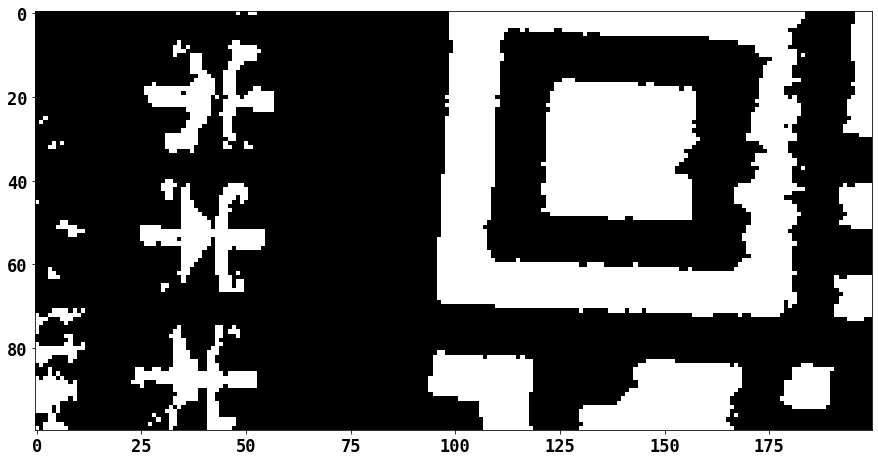

In [ ]:
image = images['test2'][0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
draw = DynamicFig(figure=plt.figure(figsize=(15, 20), facecolor='white'))
draw.plot_image(image[1100:1200,500:700] > 128)
draw.show()

In [ ]:
image = cv2.normalize(image,image,0,255,cv2.NORM_MINMAX)
image = cv2.medianBlur(image,5)

Pattern [(10, array([2311, 2321,    1])), (16, array([2309, 2324,    0])), (49, array([1395, 1406,    0])), (75, array([2219, 2250,    0])), (113, array([1046, 1065,    0])), (128, array([2234, 2271,    0])), (134, array([3526, 3539,    1])), (143, array([1215, 1230,    0])), (147, array([3307, 3325,    0])), (160, array([ 992, 1022,    0])), (167, array([ 987, 1007,    0])), (168, array([ 986, 1009,    0])), (170, array([938, 960,   1])), (196, array([ 985, 1010,    0])), (232, array([1406, 1455,    0])), (234, array([1408, 1468,    0])), (259, array([980, 993,   0])), (260, array([980, 993,   0])), (261, array([980, 992,   0])), (262, array([860, 881,   1])), (262, array([980, 992,   0])), (263, array([980, 992,   0])), (278, array([937, 963,   0])), (279, array([938, 963,   0])), (280, array([938, 963,   0])), (282, array([1276, 1288,    0])), (296, array([ 965, 1016,    0])), (300, array([896, 919,   0])), (308, array([435, 441,   0])), (339, array([890, 915,   0])), (350, array([ 

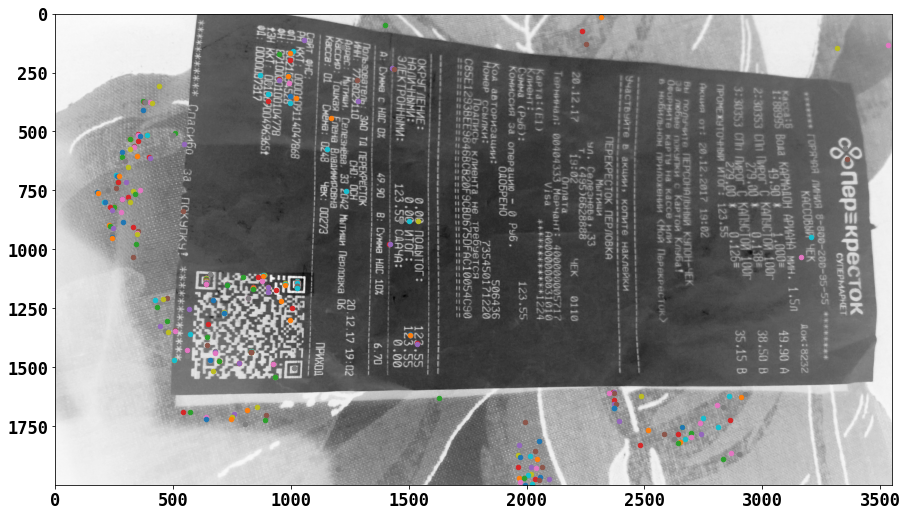

In [ ]:
draw = DynamicFig(figure=plt.figure(figsize=(15, 20), facecolor='white'))
pattern = get_pattern(image)
ax = draw.plot_image(image)
for row, data in pattern:
    ax.scatter(np.average([data[0], data[1]]), [row], s=20)

In [ ]:
local_image = image[1100:1200,500:700]
local_image = image[1100:1200,900:1100]

In [ ]:
local_image = cv2.normalize(local_image,local_image,0,255,cv2.NORM_MINMAX)
local_image = cv2.medianBlur(local_image,5)


Pattern [(35, array([112, 137,   1]), (88, -2, 162, 72)), (36, array([111, 141,   1]), (88, -1, 162, 73)), (37, array([110, 142,   1]), (88, 0, 162, 74)), (38, array([111, 143,   1]), (88, 1, 162, 75)), (39, array([111, 143,   1]), (88, 2, 162, 76)), (40, array([110, 143,   1]), (88, 3, 162, 77)), (41, array([110, 143,   1]), (88, 4, 162, 78)), (42, array([110, 143,   1]), (88, 5, 162, 79)), (43, array([110, 143,   1]), (88, 6, 162, 80)), (44, array([64, 86,  0]), (44, 12, 109, 76)), (44, array([110, 143,   1]), (87, 7, 162, 81)), (45, array([65, 86,  0]), (44, 13, 109, 77)), (45, array([110, 143,   1]), (87, 8, 162, 82)), (46, array([65, 86,  0]), (44, 14, 109, 78)), (47, array([65, 86,  0]), (44, 15, 109, 79)), (48, array([66, 86,  0]), (45, 16, 109, 80)), (49, array([66, 86,  0]), (45, 17, 109, 81)), (50, array([66, 86,  0]), (45, 18, 109, 82)), (54, array([110, 141,   1]), (87, 17, 161, 91)), (55, array([110, 141,   1]), (87, 18, 161, 92)), (57, array([110, 140,   1]), (87, 20, 161

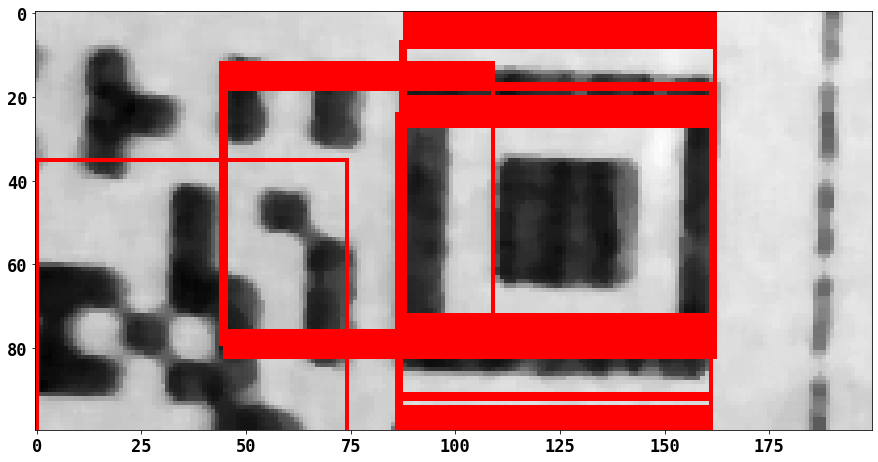

In [ ]:


draw = DynamicFig(figure=plt.figure(figsize=(15, 20), facecolor='white'))
pattern = get_pattern(local_image)


draw_image = cv2.cvtColor(local_image,cv2.COLOR_GRAY2RGB)


for row, data, rec in pattern:

    point1 = (rec[0], rec[1]) 
    point2 = (rec[2], rec[3])

    draw_image = cv2.rectangle(draw_image, point1, point2, rec_color, rec_thickness)
ax = draw.plot_image(draw_image)


Pattern [(111, array([36, 64,  1]), (76, 14, 146, 85)), (112, array([35, 64,  1]), (77, 14, 147, 85)), (113, array([35, 64,  1]), (78, 14, 148, 85)), (114, array([35, 64,  1]), (79, 14, 149, 85)), (115, array([35, 64,  1]), (80, 14, 150, 85)), (116, array([35, 64,  1]), (81, 14, 151, 85)), (117, array([35, 64,  1]), (82, 14, 152, 85)), (118, array([35, 64,  1]), (83, 14, 153, 85)), (120, array([35, 65,  1]), (85, 15, 155, 86)), (121, array([35, 65,  1]), (86, 15, 156, 86)), (122, array([35, 65,  1]), (87, 15, 157, 86)), (123, array([35, 65,  1]), (88, 15, 158, 86)), (124, array([35, 65,  1]), (89, 15, 159, 86)), (125, array([35, 65,  1]), (89, 14, 161, 86)), (126, array([35, 65,  1]), (90, 14, 162, 86)), (127, array([35, 65,  1]), (91, 14, 163, 86)), (128, array([35, 65,  1]), (92, 14, 164, 86)), (129, array([35, 65,  1]), (94, 15, 164, 86)), (130, array([35, 65,  1]), (95, 15, 165, 86)), (131, array([35, 65,  1]), (96, 15, 166, 86)), (132, array([35, 65,  1]), (97, 15, 167, 86)), (133

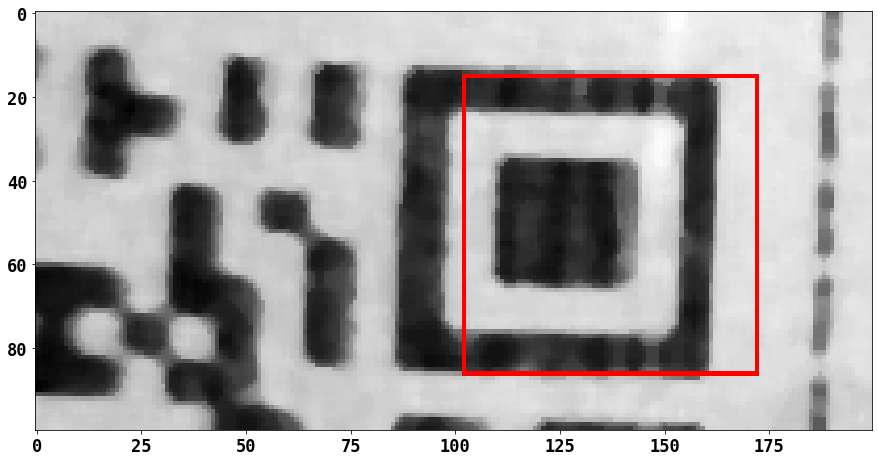

In [332]:
pattern = get_pattern(local_image)
boxes = np.array([rec for _, _, rec in pattern])
draw = DynamicFig(figure=plt.figure(figsize=(15, 20), facecolor='white'))
res_boxes = NMS(boxes)
draw_image = cv2.cvtColor(local_image,cv2.COLOR_GRAY2RGB)
for rec in res_boxes:
    draw_image = cv2.rectangle(draw_image, (rec[0], rec[1]), (rec[2], rec[3]), rec_color, rec_thickness)
ax = draw.plot_image(draw_image)

# Итоговый алгоритм

In [11]:
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.normalize(image,image,0,255,cv2.NORM_MINMAX)
    image = cv2.medianBlur(image,3)
    image = cv2.bilateralFilter(image,9,75,75)

    pattern = get_pattern(image)
    boxes = np.array([rec for _, _, rec in pattern])
    
    res_boxes = NMS(boxes)
    draw_image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    for rec in res_boxes:
        draw_image = cv2.rectangle(draw_image, (rec[0], rec[1]), (rec[2], rec[3]), rec_color, 3)
    return draw_image


Pattern [(623, array([1053, 1087,    1]), (1030, 583, 1110, 663)), (624, array([1053, 1087,    1]), (1030, 584, 1110, 664)), (625, array([1053, 1087,    1]), (1030, 585, 1110, 665)), (626, array([1053, 1087,    1]), (1030, 586, 1110, 666)), (640, array([1053, 1086,    1]), (1029, 600, 1109, 680)), (641, array([1054, 1086,    1]), (1029, 601, 1109, 681)), (646, array([959, 993,   1]), (936, 606, 1017, 686)), (780, array([880, 915,   1]), (857, 739, 939, 821)), (987, array([1033, 1066,    1]), (1009, 946, 1091, 1028)), (988, array([1033, 1067,    1]), (1009, 947, 1091, 1029)), (994, array([1033, 1067,    1]), (1009, 953, 1091, 1035)), (995, array([1033, 1067,    1]), (1009, 954, 1091, 1036)), (1011, array([1032, 1066,    1]), (1008, 970, 1090, 1052)), (1012, array([1032, 1066,    1]), (1008, 972, 1089, 1052)), (1013, array([1032, 1066,    1]), (1008, 973, 1089, 1053)), (1014, array([1033, 1066,    1]), (1008, 974, 1089, 1054)), (1015, array([1033, 1066,    1]), (1008, 975, 1089, 1055)), 

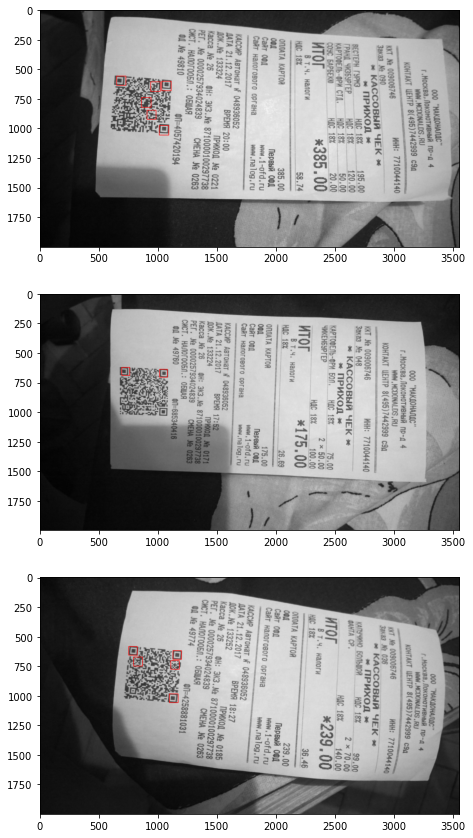

In [15]:
draw = DynamicFig(figure=plt.figure(figsize=(15, 20), facecolor='white'))
for i in range(12, 15):
    image = images['test2'][i]
    draw_image = process_image(image)
    draw.plot_image(draw_image)

# Dump results

In [16]:
!mkdir -p ./result/test1/
!mkdir -p ./result/test2/
!mkdir -p ./result/test3/

In [ ]:
for dataset in ['test1', 'test2', 'test3']:
    for i, image in enumerate(tqdm.tqdm(images[dataset])):
        draw_image = process_image(image)
        mpimg.imsave(f'./result/{dataset}/{str(i+1).zfill(4)}.png', draw_image)

  0%|          | 0/47 [00:00<?, ?it/s]

Pattern []


  2%|▏         | 1/47 [00:05<04:28,  5.84s/it]

Pattern [(2463, array([1363, 1391,    1]), (1343, 2429, 1411, 2497)), (2464, array([1363, 1391,    1]), (1343, 2430, 1411, 2498)), (2465, array([1363, 1391,    1]), (1343, 2431, 1411, 2499)), (2469, array([1363, 1391,    1]), (1343, 2435, 1411, 2503)), (2470, array([1363, 1391,    1]), (1343, 2436, 1411, 2504)), (2471, array([1363, 1391,    1]), (1343, 2437, 1411, 2505)), (2472, array([1363, 1391,    1]), (1343, 2438, 1411, 2506)), (2473, array([1363, 1391,    1]), (1343, 2439, 1411, 2507)), (2474, array([1363, 1391,    1]), (1343, 2440, 1411, 2508)), (2475, array([1363, 1391,    1]), (1343, 2441, 1411, 2509)), (2476, array([1363, 1391,    1]), (1343, 2442, 1411, 2510)), (2477, array([1363, 1391,    1]), (1343, 2443, 1411, 2511)), (2478, array([1363, 1391,    1]), (1343, 2444, 1411, 2512)), (2479, array([1363, 1391,    1]), (1343, 2445, 1411, 2513)), (2480, array([1363, 1391,    1]), (1343, 2446, 1411, 2514)), (2481, array([1363, 1391,    1]), (1343, 2447, 1411, 2515)), (2482, array([1

  4%|▍         | 2/47 [00:10<04:04,  5.43s/it]

Pattern [(2575, array([1152, 1183,    1]), (1129, 2537, 1205, 2613)), (2631, array([1033, 1064,    1]), (1011, 2594, 1086, 2668)), (2632, array([1033, 1064,    1]), (1011, 2595, 1086, 2669)), (2633, array([1033, 1064,    1]), (1011, 2596, 1086, 2670)), (2634, array([1033, 1064,    1]), (1011, 2597, 1086, 2671)), (2634, array([1196, 1228,    1]), (1175, 2597, 1250, 2671)), (2635, array([1033, 1064,    1]), (1011, 2598, 1086, 2672)), (2636, array([1033, 1064,    1]), (1011, 2599, 1086, 2673)), (2637, array([1033, 1064,    1]), (1011, 2600, 1086, 2674)), (2638, array([1033, 1064,    1]), (1011, 2601, 1086, 2675)), (2639, array([1033, 1064,    1]), (1011, 2602, 1086, 2676)), (2640, array([1033, 1064,    1]), (1011, 2602, 1087, 2678)), (2649, array([1033, 1065,    1]), (1011, 2611, 1087, 2687)), (2650, array([1033, 1065,    1]), (1011, 2612, 1087, 2688)), (2651, array([1033, 1065,    1]), (1011, 2613, 1087, 2689)), (2652, array([1033, 1065,    1]), (1011, 2614, 1087, 2690)), (2653, array([1

  6%|▋         | 3/47 [00:17<04:21,  5.95s/it]

Pattern [(1939, array([ 997, 1022,    1]), (979, 1909, 1040, 1969)), (1940, array([ 997, 1022,    1]), (979, 1910, 1040, 1970)), (1941, array([ 997, 1022,    1]), (979, 1911, 1040, 1971)), (1945, array([ 997, 1022,    1]), (979, 1915, 1040, 1975))]


  9%|▊         | 4/47 [00:22<03:57,  5.53s/it]

Pattern []


 11%|█         | 5/47 [00:27<03:44,  5.34s/it]

Pattern [(2632, array([1549, 1572,    1]), (1533, 2605, 1588, 2659)), (2913, array([1259, 1283,    1]), (1243, 2885, 1299, 2941)), (2914, array([1259, 1283,    1]), (1243, 2886, 1299, 2942)), (2920, array([1259, 1283,    1]), (1243, 2892, 1299, 2948)), (2921, array([1259, 1283,    1]), (1243, 2893, 1299, 2949)), (1280, array([2904, 2928,    1]), (1252, 2888, 1308, 2944))]


 13%|█▎        | 6/47 [00:33<03:51,  5.64s/it]

Pattern [(2548, array([ 997, 1019,    1]), (983, 2523, 1033, 2573)), (2688, array([1670, 1695,    1]), (1652, 2658, 1713, 2718)), (2689, array([1670, 1695,    1]), (1652, 2659, 1713, 2719)), (2690, array([1670, 1695,    1]), (1652, 2660, 1713, 2720)), (2697, array([1367, 1393,    1]), (1349, 2666, 1411, 2728)), (2698, array([1367, 1393,    1]), (1349, 2667, 1411, 2729)), (2699, array([1367, 1393,    1]), (1349, 2668, 1411, 2730)), (2700, array([1367, 1393,    1]), (1349, 2669, 1411, 2731)), (2701, array([1367, 1393,    1]), (1349, 2670, 1411, 2732)), (2708, array([1366, 1392,    1]), (1348, 2677, 1410, 2739)), (2709, array([1366, 1392,    1]), (1348, 2678, 1410, 2740)), (2710, array([1366, 1392,    1]), (1348, 2679, 1410, 2741)), (2711, array([1366, 1392,    1]), (1348, 2680, 1410, 2742)), (2712, array([1366, 1392,    1]), (1348, 2681, 1410, 2743)), (2713, array([1366, 1392,    1]), (1348, 2682, 1410, 2744)), (2714, array([1366, 1392,    1]), (1348, 2683, 1410, 2745)), (2715, array([13

 15%|█▍        | 7/47 [00:40<03:55,  5.88s/it]

Pattern [(2815, array([1303, 1330,    1]), (1283, 2782, 1350, 2848)), (2816, array([1303, 1330,    1]), (1283, 2783, 1350, 2849)), (2817, array([1303, 1330,    1]), (1283, 2784, 1350, 2850)), (2823, array([1303, 1331,    1]), (1283, 2789, 1351, 2857)), (2824, array([1303, 1331,    1]), (1283, 2790, 1351, 2858)), (2833, array([1304, 1332,    1]), (1284, 2799, 1352, 2867)), (2834, array([1304, 1332,    1]), (1284, 2800, 1352, 2868)), (2835, array([1304, 1332,    1]), (1284, 2801, 1352, 2869)), (2836, array([1304, 1332,    1]), (1284, 2802, 1352, 2870)), (2837, array([1304, 1332,    1]), (1284, 2803, 1352, 2871)), (2838, array([1304, 1332,    1]), (1284, 2804, 1352, 2872)), (2839, array([1304, 1332,    1]), (1284, 2805, 1352, 2873)), (2840, array([1304, 1332,    1]), (1284, 2806, 1352, 2874)), (2841, array([1304, 1332,    1]), (1284, 2807, 1352, 2875)), (2842, array([1304, 1332,    1]), (1284, 2808, 1352, 2876))]


 17%|█▋        | 8/47 [00:45<03:45,  5.79s/it]

Pattern [(1097, array([2661, 2688,    1]), (1066, 2643, 1128, 2706)), (1098, array([2661, 2688,    1]), (1067, 2643, 1129, 2706)), (1099, array([2661, 2688,    1]), (1068, 2643, 1130, 2706)), (1100, array([2661, 2688,    1]), (1069, 2643, 1131, 2706))]


 19%|█▉        | 9/47 [00:51<03:46,  5.97s/it]

Pattern [(2750, array([882, 907,   1]), (864, 2720, 925, 2780)), (2751, array([882, 907,   1]), (864, 2721, 925, 2781)), (2752, array([882, 907,   1]), (864, 2722, 925, 2782)), (2753, array([882, 907,   1]), (864, 2723, 925, 2783)), (2754, array([882, 907,   1]), (864, 2724, 925, 2784)), (2755, array([882, 907,   1]), (864, 2725, 925, 2785)), (2756, array([882, 907,   1]), (864, 2726, 925, 2786)), (2757, array([882, 907,   1]), (864, 2727, 925, 2787)), (2758, array([882, 907,   1]), (864, 2728, 925, 2788)), (2759, array([882, 907,   1]), (864, 2729, 925, 2789)), (2760, array([882, 907,   1]), (864, 2730, 925, 2790)), (2761, array([882, 907,   1]), (864, 2731, 925, 2791)), (3079, array([900, 927,   1]), (882, 3048, 945, 3110)), (3080, array([900, 927,   1]), (882, 3049, 945, 3111))]


 21%|██▏       | 10/47 [00:58<03:47,  6.16s/it]

Pattern [(2447, array([1222, 1249,    1]), (1204, 2416, 1267, 2478)), (2450, array([1222, 1249,    1]), (1204, 2419, 1267, 2481)), (2451, array([1222, 1249,    1]), (1204, 2420, 1267, 2482)), (2452, array([1222, 1249,    1]), (1204, 2421, 1267, 2483)), (2453, array([1222, 1249,    1]), (1204, 2422, 1267, 2484)), (2454, array([907, 935,   1]), (889, 2422, 953, 2486)), (2455, array([907, 935,   1]), (889, 2423, 953, 2487)), (2456, array([907, 935,   1]), (889, 2424, 953, 2488)), (1238, array([2434, 2462,    1]), (1206, 2416, 1270, 2480)), (1239, array([2434, 2462,    1]), (1207, 2416, 1271, 2480)), (1240, array([2434, 2462,    1]), (1208, 2416, 1272, 2480)), (1241, array([2434, 2462,    1]), (1209, 2416, 1273, 2480))]


 23%|██▎       | 11/47 [01:03<03:27,  5.78s/it]

Pattern [(924, array([2391, 2420,    1]), (890, 2371, 958, 2440)), (925, array([2391, 2420,    1]), (891, 2371, 959, 2440)), (926, array([2391, 2420,    1]), (892, 2371, 960, 2440)), (927, array([2391, 2420,    1]), (893, 2371, 961, 2440)), (928, array([2391, 2420,    1]), (894, 2371, 962, 2440)), (929, array([2391, 2420,    1]), (895, 2371, 963, 2440)), (930, array([2391, 2420,    1]), (896, 2371, 964, 2440)), (931, array([2391, 2420,    1]), (897, 2371, 965, 2440)), (932, array([2391, 2420,    1]), (898, 2371, 966, 2440)), (933, array([2391, 2420,    1]), (899, 2371, 967, 2440)), (934, array([2391, 2420,    1]), (900, 2371, 968, 2440)), (935, array([2391, 2420,    1]), (901, 2371, 969, 2440)), (936, array([2391, 2420,    1]), (902, 2371, 970, 2440)), (937, array([2391, 2420,    1]), (903, 2371, 971, 2440)), (1249, array([2381, 2408,    1]), (1216, 2361, 1282, 2428)), (1250, array([2381, 2408,    1]), (1217, 2361, 1283, 2428)), (1251, array([2381, 2408,    1]), (1218, 2361, 1284, 2428

 26%|██▌       | 12/47 [01:09<03:27,  5.92s/it]

Pattern []


 28%|██▊       | 13/47 [01:15<03:22,  5.95s/it]

Pattern [(691, array([973, 994,   1]), (959, 667, 1008, 715)), (1903, array([883, 913,   1]), (862, 1867, 934, 1939)), (1921, array([1238, 1267,    1]), (1217, 1886, 1288, 1956)), (1922, array([1238, 1267,    1]), (1217, 1887, 1288, 1957)), (1924, array([1238, 1267,    1]), (1217, 1889, 1288, 1959)), (1925, array([1238, 1267,    1]), (1217, 1890, 1288, 1960)), (2252, array([871, 901,   1]), (849, 2215, 923, 2289)), (2253, array([871, 901,   1]), (849, 2216, 923, 2290)), (2260, array([870, 901,   1]), (849, 2223, 923, 2297)), (2261, array([870, 901,   1]), (849, 2224, 923, 2298)), (2262, array([870, 901,   1]), (849, 2225, 923, 2299)), (2263, array([870, 901,   1]), (849, 2226, 923, 2300)), (2264, array([870, 901,   1]), (849, 2227, 923, 2301)), (2265, array([870, 901,   1]), (849, 2228, 923, 2302)), (2266, array([870, 901,   1]), (849, 2229, 923, 2303)), (2267, array([870, 901,   1]), (849, 2230, 923, 2304)), (2268, array([870, 901,   1]), (848, 2231, 923, 2305)), (2269, array([870, 90

 30%|██▉       | 14/47 [01:22<03:21,  6.10s/it]

Pattern [(2156, array([948, 977,   1]), (927, 2121, 998, 2191)), (2157, array([948, 977,   1]), (927, 2122, 998, 2192)), (2158, array([948, 977,   1]), (927, 2123, 998, 2193)), (2159, array([948, 977,   1]), (927, 2124, 998, 2194)), (2160, array([948, 977,   1]), (927, 2125, 998, 2195)), (2161, array([948, 977,   1]), (927, 2125, 999, 2197)), (2190, array([844, 874,   1]), (823, 2154, 895, 2226)), (2191, array([844, 874,   1]), (823, 2155, 895, 2227)), (2192, array([844, 874,   1]), (823, 2156, 895, 2228)), (2193, array([844, 874,   1]), (823, 2157, 895, 2229)), (2194, array([844, 874,   1]), (823, 2158, 895, 2230)), (2195, array([844, 874,   1]), (823, 2159, 895, 2231)), (2196, array([844, 874,   1]), (823, 2160, 895, 2232)), (2197, array([844, 874,   1]), (823, 2161, 895, 2233)), (2198, array([844, 874,   1]), (823, 2162, 895, 2234)), (2199, array([844, 874,   1]), (823, 2163, 895, 2235)), (2200, array([844, 874,   1]), (823, 2164, 895, 2236)), (2201, array([844, 874,   1]), (823, 21

 32%|███▏      | 15/47 [01:28<03:14,  6.07s/it]

Pattern [(2965, array([904, 926,   1]), (888, 2938, 942, 2992)), (2966, array([904, 926,   1]), (888, 2939, 942, 2993)), (2967, array([904, 926,   1]), (888, 2940, 942, 2994)), (2974, array([904, 926,   1]), (888, 2947, 942, 3001)), (2976, array([904, 926,   1]), (888, 2949, 942, 3003)), (2977, array([904, 926,   1]), (888, 2950, 942, 3004)), (2978, array([904, 926,   1]), (888, 2951, 942, 3005)), (2983, array([904, 926,   1]), (888, 2956, 942, 3010)), (2984, array([904, 926,   1]), (888, 2957, 942, 3011))]


 34%|███▍      | 16/47 [01:33<02:59,  5.78s/it]

Pattern [(2454, array([1159, 1188,    1]), (1138, 2419, 1209, 2489)), (2455, array([1159, 1188,    1]), (1138, 2420, 1209, 2490)), (2610, array([839, 870,   1]), (818, 2573, 892, 2647)), (2830, array([792, 822,   1]), (769, 2792, 845, 2868)), (2832, array([791, 823,   1]), (770, 2795, 844, 2869)), (2847, array([791, 823,   1]), (769, 2809, 845, 2885)), (2848, array([791, 823,   1]), (769, 2810, 845, 2886)), (2861, array([791, 822,   1]), (769, 2824, 844, 2898)), (2862, array([791, 822,   1]), (769, 2824, 845, 2900)), (805, array([2447, 2478,    1]), (767, 2425, 843, 2501)), (883, array([2692, 2725,    1]), (844, 2669, 922, 2748)), (884, array([2692, 2725,    1]), (845, 2669, 923, 2748)), (885, array([2692, 2725,    1]), (846, 2669, 924, 2748)), (886, array([2692, 2725,    1]), (847, 2669, 925, 2748)), (887, array([2692, 2725,    1]), (848, 2669, 926, 2748)), (1154, array([2690, 2724,    1]), (1115, 2667, 1193, 2746)), (1155, array([2690, 2724,    1]), (1115, 2667, 1195, 2747)), (1156, 

 36%|███▌      | 17/47 [01:39<02:58,  5.94s/it]

Pattern [(2487, array([1197, 1227,    1]), (1176, 2451, 1248, 2523)), (2488, array([1197, 1227,    1]), (1176, 2452, 1248, 2524)), (2489, array([832, 863,   1]), (811, 2453, 884, 2525)), (2490, array([832, 863,   1]), (811, 2454, 884, 2526)), (2491, array([832, 863,   1]), (811, 2455, 884, 2527)), (2507, array([1197, 1228,    1]), (1176, 2471, 1249, 2543)), (2508, array([1197, 1228,    1]), (1176, 2472, 1249, 2544)), (2883, array([828, 860,   1]), (806, 2845, 883, 2921)), (2884, array([828, 860,   1]), (806, 2846, 883, 2922)), (2885, array([828, 860,   1]), (806, 2847, 883, 2923)), (2886, array([828, 860,   1]), (805, 2847, 883, 2925)), (2887, array([828, 860,   1]), (805, 2848, 883, 2926)), (2888, array([828, 860,   1]), (805, 2849, 883, 2927)), (2889, array([828, 860,   1]), (805, 2850, 883, 2928)), (2890, array([828, 860,   1]), (805, 2851, 883, 2929)), (2898, array([828, 860,   1]), (805, 2860, 882, 2936)), (2899, array([828, 860,   1]), (805, 2860, 883, 2938)), (2900, array([828, 

 38%|███▊      | 18/47 [01:46<03:01,  6.24s/it]

Pattern [(2200, array([973, 997,   1]), (957, 2172, 1013, 2228)), (2498, array([738, 773,   1]), (714, 2457, 796, 2539)), (2499, array([738, 773,   1]), (714, 2458, 796, 2540)), (2500, array([738, 772,   1]), (714, 2459, 796, 2541)), (2501, array([738, 772,   1]), (714, 2460, 796, 2542)), (2502, array([738, 772,   1]), (714, 2461, 796, 2543)), (2503, array([738, 772,   1]), (714, 2462, 796, 2544)), (2504, array([738, 772,   1]), (714, 2463, 796, 2545)), (2505, array([738, 772,   1]), (714, 2464, 796, 2546)), (2508, array([1096, 1131,    1]), (1073, 2468, 1154, 2548)), (2509, array([1096, 1131,    1]), (1073, 2469, 1154, 2549)), (2510, array([1096, 1131,    1]), (1073, 2470, 1154, 2550)), (2512, array([737, 772,   1]), (714, 2471, 796, 2553)), (2513, array([737, 772,   1]), (714, 2472, 796, 2554)), (2514, array([737, 772,   1]), (714, 2473, 796, 2555)), (2515, array([737, 772,   1]), (714, 2474, 796, 2556)), (2516, array([737, 772,   1]), (713, 2475, 796, 2557)), (2517, array([737, 772,

 40%|████      | 19/47 [01:53<02:57,  6.34s/it]

Pattern []


 43%|████▎     | 20/47 [01:59<02:50,  6.30s/it]

Pattern [(2665, array([ 978, 1010,    1]), (957, 2628, 1032, 2702)), (2666, array([ 978, 1010,    1]), (957, 2629, 1032, 2703)), (2668, array([ 978, 1010,    1]), (956, 2630, 1032, 2706)), (2669, array([ 978, 1010,    1]), (956, 2631, 1032, 2707)), (2670, array([ 978, 1010,    1]), (956, 2632, 1032, 2708)), (2671, array([ 978, 1010,    1]), (956, 2633, 1032, 2709)), (2672, array([ 978, 1010,    1]), (956, 2634, 1032, 2710)), (2673, array([ 978, 1010,    1]), (956, 2635, 1032, 2711)), (2674, array([ 978, 1010,    1]), (956, 2636, 1032, 2712)), (2675, array([ 978, 1010,    1]), (956, 2637, 1032, 2713)), (2676, array([ 978, 1010,    1]), (956, 2638, 1032, 2714)), (2677, array([ 978, 1010,    1]), (956, 2639, 1032, 2715)), (2678, array([ 978, 1010,    1]), (956, 2640, 1032, 2716)), (2679, array([ 978, 1010,    1]), (956, 2641, 1032, 2717)), (2680, array([ 978, 1010,    1]), (956, 2642, 1032, 2718)), (2681, array([ 978, 1010,    1]), (956, 2643, 1032, 2719)), (2682, array([ 978, 1009,    1]

 45%|████▍     | 21/47 [02:05<02:42,  6.25s/it]

Pattern [(2472, array([1139, 1169,    1]), (1118, 2436, 1190, 2508)), (2480, array([780, 811,   1]), (759, 2444, 832, 2516)), (2481, array([780, 811,   1]), (759, 2445, 832, 2517)), (2482, array([780, 811,   1]), (759, 2446, 832, 2518)), (2484, array([1139, 1169,    1]), (1118, 2448, 1190, 2520)), (2485, array([1139, 1169,    1]), (1118, 2449, 1190, 2521)), (2486, array([1139, 1169,    1]), (1118, 2450, 1190, 2522)), (2487, array([1139, 1169,    1]), (1118, 2451, 1190, 2523)), (2488, array([1139, 1169,    1]), (1118, 2452, 1190, 2524)), (2628, array([1015, 1046,    1]), (994, 2592, 1067, 2664)), (2629, array([1015, 1046,    1]), (994, 2593, 1067, 2665)), (2630, array([1015, 1046,    1]), (994, 2594, 1067, 2666)), (2631, array([1015, 1046,    1]), (994, 2595, 1067, 2667)), (2632, array([1015, 1046,    1]), (994, 2596, 1067, 2668)), (2633, array([1015, 1046,    1]), (994, 2596, 1068, 2670)), (2856, array([777, 809,   1]), (755, 2818, 831, 2894)), (2857, array([777, 809,   1]), (755, 2819

 47%|████▋     | 22/47 [02:11<02:36,  6.26s/it]

Pattern [(2618, array([1095, 1125,    1]), (1074, 2582, 1146, 2654)), (2619, array([1095, 1125,    1]), (1074, 2583, 1146, 2655)), (2620, array([1095, 1125,    1]), (1074, 2584, 1146, 2656)), (2621, array([1095, 1125,    1]), (1074, 2585, 1146, 2657)), (3011, array([732, 763,   1]), (710, 2974, 785, 3048)), (3012, array([732, 763,   1]), (710, 2975, 785, 3049)), (736, array([2997, 3030,    1]), (697, 2975, 775, 3054)), (737, array([2997, 3030,    1]), (698, 2975, 776, 3054)), (738, array([2997, 3030,    1]), (699, 2975, 777, 3053)), (739, array([2997, 3030,    1]), (700, 2975, 778, 3053)), (740, array([2997, 3030,    1]), (701, 2975, 779, 3053)), (741, array([2997, 3030,    1]), (702, 2975, 780, 3053)), (742, array([2997, 3030,    1]), (703, 2975, 781, 3053)), (743, array([2997, 3030,    1]), (704, 2975, 782, 3053)), (744, array([2997, 3030,    1]), (705, 2975, 783, 3053)), (745, array([2997, 3030,    1]), (706, 2975, 784, 3053)), (746, array([2997, 3030,    1]), (707, 2975, 785, 3053)

 49%|████▉     | 23/47 [02:17<02:27,  6.15s/it]

Pattern [(2887, array([711, 744,   1]), (688, 2848, 767, 2926)), (2888, array([711, 744,   1]), (688, 2849, 767, 2927)), (2889, array([711, 744,   1]), (688, 2850, 767, 2928)), (2890, array([711, 744,   1]), (689, 2851, 767, 2929)), (2891, array([711, 744,   1]), (689, 2852, 767, 2930)), (2892, array([711, 744,   1]), (689, 2854, 766, 2930)), (2893, array([711, 744,   1]), (688, 2854, 766, 2932)), (2894, array([711, 744,   1]), (688, 2855, 767, 2933)), (2895, array([711, 744,   1]), (688, 2856, 767, 2934)), (2896, array([711, 744,   1]), (688, 2857, 767, 2935)), (2897, array([711, 744,   1]), (688, 2858, 767, 2936)), (2898, array([711, 744,   1]), (688, 2859, 767, 2937)), (2899, array([711, 744,   1]), (688, 2860, 767, 2938)), (2900, array([711, 744,   1]), (688, 2861, 767, 2939)), (2901, array([711, 744,   1]), (688, 2862, 767, 2940)), (2902, array([711, 744,   1]), (688, 2863, 766, 2941)), (2908, array([711, 744,   1]), (688, 2869, 767, 2947)), (2910, array([711, 744,   1]), (688, 28

 51%|█████     | 24/47 [02:24<02:23,  6.24s/it]

Pattern [(2519, array([1211, 1241,    1]), (1190, 2483, 1262, 2555)), (2520, array([1211, 1241,    1]), (1190, 2484, 1262, 2556)), (2521, array([1211, 1241,    1]), (1190, 2485, 1262, 2557)), (2522, array([1211, 1241,    1]), (1190, 2486, 1262, 2558)), (2523, array([1211, 1241,    1]), (1190, 2487, 1262, 2559)), (2524, array([1211, 1241,    1]), (1190, 2488, 1262, 2560)), (2525, array([1211, 1241,    1]), (1190, 2489, 1262, 2561)), (2526, array([1211, 1241,    1]), (1190, 2490, 1262, 2562)), (2527, array([1211, 1241,    1]), (1190, 2491, 1262, 2563)), (2528, array([1211, 1241,    1]), (1190, 2492, 1262, 2564)), (2529, array([1211, 1241,    1]), (1190, 2493, 1262, 2565)), (2534, array([850, 881,   1]), (829, 2497, 903, 2571)), (2535, array([850, 881,   1]), (829, 2498, 903, 2572)), (2545, array([1212, 1242,    1]), (1191, 2509, 1263, 2581)), (2546, array([1212, 1242,    1]), (1191, 2510, 1263, 2582)), (2668, array([960, 990,   1]), (937, 2631, 1012, 2705)), (2669, array([960, 990,   1])

 53%|█████▎    | 25/47 [02:30<02:18,  6.29s/it]

Pattern []


 55%|█████▌    | 26/47 [02:35<02:05,  5.96s/it]

Pattern [(158, array([1077, 1093,    1]), (1065, 138, 1105, 178)), (2302, array([1244, 1262,    1]), (1232, 2281, 1274, 2323)), (2303, array([1244, 1262,    1]), (1232, 2282, 1274, 2324)), (2672, array([878, 904,   1]), (860, 2641, 922, 2703)), (2673, array([878, 904,   1]), (860, 2642, 922, 2704)), (2674, array([878, 904,   1]), (860, 2643, 922, 2705)), (2675, array([878, 904,   1]), (860, 2644, 922, 2706)), (2676, array([878, 904,   1]), (860, 2645, 922, 2707)), (2677, array([878, 904,   1]), (860, 2646, 922, 2708)), (2678, array([878, 904,   1]), (860, 2647, 922, 2709)), (2679, array([878, 904,   1]), (860, 2648, 922, 2710)), (2687, array([878, 905,   1]), (860, 2656, 923, 2718))]


 57%|█████▋    | 27/47 [02:41<02:00,  6.02s/it]

Pattern [(2351, array([860, 876,   1]), (848, 2331, 888, 2371)), (2446, array([883, 900,   1]), (871, 2426, 912, 2466)), (2447, array([883, 900,   1]), (871, 2427, 912, 2467))]


 60%|█████▉    | 28/47 [02:47<01:51,  5.86s/it]

Pattern [(1630, array([886, 921,   1]), (863, 1590, 944, 1670)), (1631, array([886, 921,   1]), (862, 1590, 944, 1672)), (1632, array([886, 920,   1]), (862, 1591, 944, 1673)), (1633, array([886, 920,   1]), (862, 1592, 944, 1674)), (1634, array([886, 920,   1]), (862, 1593, 944, 1675)), (1635, array([886, 920,   1]), (862, 1594, 944, 1676)), (1636, array([886, 920,   1]), (862, 1595, 944, 1677)), (1637, array([885, 920,   1]), (862, 1596, 944, 1678)), (1638, array([885, 920,   1]), (862, 1598, 943, 1678)), (1639, array([885, 920,   1]), (861, 1598, 943, 1680)), (1640, array([885, 920,   1]), (861, 1599, 943, 1681)), (1641, array([885, 919,   1]), (861, 1600, 943, 1682)), (1642, array([885, 919,   1]), (861, 1601, 943, 1683)), (1643, array([885, 919,   1]), (861, 1602, 943, 1684)), (1644, array([885, 919,   1]), (861, 1603, 943, 1685)), (1645, array([885, 919,   1]), (861, 1604, 943, 1686)), (1646, array([884, 919,   1]), (861, 1605, 943, 1687)), (1647, array([884, 919,   1]), (861, 16

 62%|██████▏   | 29/47 [02:51<01:38,  5.49s/it]

Pattern [(2521, array([1005, 1029,    1]), (987, 2491, 1047, 2551)), (2838, array([1004, 1030,    1]), (986, 2807, 1048, 2869)), (2839, array([1004, 1030,    1]), (986, 2808, 1048, 2870)), (2840, array([1004, 1030,    1]), (986, 2809, 1048, 2871)), (2841, array([1004, 1030,    1]), (986, 2810, 1048, 2872)), (2842, array([1004, 1030,    1]), (986, 2811, 1048, 2873)), (2845, array([1004, 1030,    1]), (986, 2814, 1048, 2876)), (2846, array([1004, 1030,    1]), (986, 2815, 1048, 2877)), (2847, array([1004, 1030,    1]), (986, 2816, 1048, 2878)), (2848, array([1004, 1030,    1]), (986, 2817, 1048, 2879)), (2849, array([1004, 1030,    1]), (986, 2818, 1048, 2880)), (2850, array([1004, 1030,    1]), (986, 2819, 1048, 2881)), (2851, array([1004, 1030,    1]), (986, 2820, 1048, 2882)), (2852, array([1004, 1030,    1]), (986, 2821, 1048, 2883))]


 64%|██████▍   | 30/47 [02:58<01:39,  5.86s/it]

Pattern []


 66%|██████▌   | 31/47 [03:03<01:26,  5.40s/it]

Pattern [(2840, array([1001, 1028,    1]), (980, 2806, 1049, 2874)), (2843, array([1000, 1029,    1]), (980, 2809, 1049, 2877)), (2844, array([1000, 1029,    1]), (980, 2810, 1049, 2878)), (2845, array([1000, 1029,    1]), (980, 2811, 1049, 2879)), (2846, array([1000, 1029,    1]), (980, 2812, 1049, 2880)), (2847, array([1000, 1029,    1]), (980, 2813, 1049, 2881)), (2848, array([1000, 1029,    1]), (980, 2814, 1049, 2882)), (2849, array([1000, 1029,    1]), (980, 2815, 1049, 2883)), (2851, array([1000, 1029,    1]), (980, 2817, 1049, 2885)), (2852, array([1000, 1029,    1]), (980, 2818, 1049, 2886)), (2853, array([1000, 1029,    1]), (980, 2819, 1049, 2887)), (2854, array([1000, 1029,    1]), (980, 2820, 1049, 2888)), (2855, array([1000, 1029,    1]), (980, 2821, 1049, 2889)), (2856, array([1000, 1029,    1]), (980, 2822, 1049, 2890)), (2857, array([1000, 1029,    1]), (980, 2823, 1049, 2891)), (2858, array([1000, 1029,    1]), (980, 2824, 1049, 2892)), (2859, array([1000, 1029,    1]

 68%|██████▊   | 32/47 [03:09<01:23,  5.58s/it]

Pattern [(1749, array([857, 890,   1]), (834, 1709, 914, 1789)), (1750, array([857, 890,   1]), (834, 1710, 914, 1790)), (1751, array([857, 890,   1]), (834, 1711, 914, 1791)), (1762, array([857, 891,   1]), (835, 1723, 914, 1801)), (1763, array([857, 891,   1]), (835, 1724, 914, 1802)), (1765, array([858, 891,   1]), (835, 1726, 914, 1804)), (1766, array([858, 891,   1]), (835, 1727, 914, 1805)), (1767, array([858, 891,   1]), (835, 1728, 914, 1806)), (1768, array([858, 891,   1]), (835, 1728, 915, 1808)), (1769, array([858, 891,   1]), (835, 1729, 915, 1809)), (1770, array([858, 890,   1]), (835, 1730, 915, 1810)), (861, array([1738, 1772,    1]), (821, 1715, 901, 1795)), (862, array([1738, 1772,    1]), (822, 1715, 902, 1795)), (863, array([1738, 1772,    1]), (823, 1715, 903, 1795)), (864, array([1738, 1772,    1]), (824, 1715, 904, 1795)), (865, array([1738, 1772,    1]), (825, 1715, 905, 1795)), (866, array([1738, 1772,    1]), (826, 1715, 906, 1795)), (867, array([1738, 1772,   

 70%|███████   | 33/47 [03:12<01:10,  5.06s/it]

Pattern []


 72%|███████▏  | 34/47 [03:17<01:04,  4.98s/it]

Pattern [(2688, array([1177, 1206,    1]), (1157, 2654, 1226, 2722)), (2960, array([937, 967,   1]), (916, 2924, 988, 2996)), (2961, array([937, 967,   1]), (916, 2925, 988, 2997)), (2968, array([937, 967,   1]), (916, 2932, 988, 3004)), (940, array([2576, 2607,    1]), (904, 2555, 976, 2627)), (941, array([2576, 2607,    1]), (905, 2555, 977, 2627)), (944, array([2576, 2607,    1]), (908, 2555, 980, 2627)), (945, array([2576, 2607,    1]), (909, 2555, 981, 2627)), (946, array([2576, 2607,    1]), (910, 2555, 982, 2627)), (947, array([2576, 2607,    1]), (911, 2555, 983, 2627)), (952, array([2576, 2606,    1]), (916, 2555, 988, 2627)), (953, array([2576, 2606,    1]), (917, 2555, 989, 2627)), (954, array([2576, 2606,    1]), (918, 2555, 990, 2627)), (956, array([2576, 2606,    1]), (921, 2555, 991, 2626)), (957, array([2576, 2606,    1]), (922, 2555, 992, 2626)), (1273, array([2565, 2594,    1]), (1238, 2544, 1308, 2615)), (1274, array([2565, 2594,    1]), (1239, 2544, 1309, 2614)), (1

 74%|███████▍  | 35/47 [03:24<01:06,  5.55s/it]

Pattern [(1645, array([1003, 1037,    1]), (980, 1605, 1060, 1685)), (1845, array([ 999, 1033,    1]), (976, 1805, 1056, 1885)), (1846, array([ 999, 1033,    1]), (976, 1806, 1056, 1886)), (1847, array([ 999, 1033,    1]), (976, 1807, 1056, 1887)), (1848, array([ 999, 1033,    1]), (976, 1808, 1056, 1888)), (1849, array([ 999, 1033,    1]), (976, 1809, 1056, 1889)), (1002, array([1841, 1873,    1]), (963, 1818, 1041, 1896)), (1003, array([1841, 1873,    1]), (964, 1818, 1042, 1896)), (1004, array([1841, 1873,    1]), (965, 1818, 1043, 1896)), (1005, array([1840, 1873,    1]), (966, 1818, 1044, 1896)), (1006, array([1840, 1873,    1]), (967, 1817, 1045, 1896)), (1007, array([1840, 1873,    1]), (968, 1817, 1046, 1896)), (1008, array([1840, 1873,    1]), (969, 1817, 1047, 1896)), (1009, array([1840, 1873,    1]), (970, 1817, 1048, 1896)), (1010, array([1840, 1873,    1]), (971, 1818, 1049, 1896)), (1011, array([1840, 1873,    1]), (972, 1818, 1050, 1896)), (1012, array([1840, 1873,    1]

 77%|███████▋  | 36/47 [03:28<00:55,  5.08s/it]

Pattern []


 79%|███████▊  | 37/47 [03:33<00:49,  4.91s/it]

Pattern [(2620, array([1355, 1382,    1]), (1337, 2589, 1400, 2651)), (2621, array([1355, 1382,    1]), (1337, 2590, 1400, 2652)), (2622, array([1355, 1382,    1]), (1337, 2591, 1400, 2653))]


 81%|████████  | 38/47 [03:39<00:49,  5.48s/it]

Pattern [(2755, array([752, 775,   1]), (2728, 736, 2782, 791)), (2756, array([752, 775,   1]), (2729, 736, 2783, 791)), (2757, array([752, 775,   1]), (2730, 736, 2784, 791)), (2758, array([752, 775,   1]), (2731, 736, 2785, 791))]


 83%|████████▎ | 39/47 [03:46<00:45,  5.74s/it]

Pattern [(2418, array([737, 764,   1]), (2385, 717, 2451, 784)), (2419, array([737, 764,   1]), (2386, 717, 2452, 784)), (2420, array([737, 764,   1]), (2387, 717, 2453, 784)), (2421, array([737, 764,   1]), (2388, 717, 2454, 784)), (2424, array([407, 435,   1]), (2390, 387, 2458, 455)), (2425, array([407, 435,   1]), (2391, 387, 2459, 455)), (2426, array([407, 435,   1]), (2392, 387, 2460, 455)), (2429, array([407, 434,   1]), (2395, 387, 2463, 455)), (2655, array([577, 624,   1]), (2599, 544, 2711, 656))]


 85%|████████▌ | 40/47 [03:51<00:39,  5.58s/it]

Pattern []


 87%|████████▋ | 41/47 [03:57<00:34,  5.67s/it]

Pattern [(2486, array([779, 808,   1]), (2451, 758, 2521, 829)), (2487, array([779, 808,   1]), (2452, 758, 2522, 829)), (2488, array([779, 808,   1]), (2453, 758, 2523, 829)), (2489, array([779, 808,   1]), (2454, 758, 2524, 829)), (2490, array([779, 808,   1]), (2455, 758, 2525, 829)), (2491, array([779, 808,   1]), (2456, 758, 2526, 829)), (2492, array([422, 453,   1]), (2456, 401, 2528, 474)), (2492, array([779, 808,   1]), (2457, 758, 2527, 829)), (2493, array([422, 453,   1]), (2457, 401, 2529, 474)), (2493, array([779, 808,   1]), (2458, 758, 2528, 829)), (2494, array([422, 453,   1]), (2458, 401, 2530, 474)), (2494, array([779, 808,   1]), (2459, 758, 2529, 829)), (2495, array([422, 453,   1]), (2459, 401, 2531, 474)), (2495, array([779, 808,   1]), (2460, 758, 2530, 829)), (2496, array([422, 453,   1]), (2460, 401, 2532, 474)), (2496, array([779, 808,   1]), (2461, 758, 2531, 829)), (2497, array([422, 453,   1]), (2461, 401, 2533, 474)), (2497, array([779, 808,   1]), (2462, 7

 89%|████████▉ | 42/47 [04:04<00:30,  6.04s/it]

Pattern []


 91%|█████████▏| 43/47 [04:10<00:24,  6.10s/it]

Pattern [(342, array([1317, 1330,    1]), (1307, 326, 1340, 358)), (2945, array([1318, 1342,    1]), (1300, 2915, 1360, 2975)), (2966, array([1318, 1342,    1]), (1300, 2936, 1360, 2996))]


 94%|█████████▎| 44/47 [04:16<00:18,  6.22s/it]

Pattern [(1415, array([1007, 1041,    1]), (983, 1374, 1065, 1456)), (1416, array([1007, 1041,    1]), (983, 1375, 1065, 1457)), (1428, array([1219, 1253,    1]), (1196, 1388, 1276, 1468)), (1429, array([1219, 1253,    1]), (1196, 1389, 1276, 1469)), (1625, array([ 992, 1026,    1]), (968, 1584, 1050, 1666)), (1626, array([ 992, 1026,    1]), (968, 1585, 1050, 1667)), (1637, array([ 992, 1025,    1]), (967, 1596, 1049, 1678)), (995, array([1611, 1646,    1]), (955, 1588, 1035, 1669)), (996, array([1611, 1646,    1]), (956, 1589, 1036, 1669)), (997, array([1612, 1646,    1]), (957, 1589, 1037, 1669)), (998, array([1612, 1646,    1]), (958, 1589, 1038, 1669)), (999, array([1612, 1646,    1]), (959, 1589, 1039, 1669)), (1000, array([1612, 1646,    1]), (960, 1589, 1040, 1669)), (1001, array([1612, 1646,    1]), (961, 1589, 1041, 1669)), (1002, array([1612, 1646,    1]), (962, 1589, 1042, 1669)), (1003, array([1612, 1646,    1]), (963, 1589, 1043, 1669)), (1004, array([1612, 1646,    1]), 

 96%|█████████▌| 45/47 [04:22<00:12,  6.04s/it]

Pattern [(2775, array([1355, 1381,    1]), (1337, 2744, 1399, 2806)), (2784, array([1356, 1382,    1]), (1338, 2753, 1400, 2815))]


 98%|█████████▊| 46/47 [04:29<00:06,  6.26s/it]

Pattern []


  0%|          | 0/48 [00:00<?, ?it/s]

Pattern [(1834, array([1870, 1880,    1]), (1862, 1821, 1888, 1847)), (624, array([1117, 1148,    1]), (586, 1094, 662, 1170)), (625, array([1116, 1148,    1]), (587, 1094, 663, 1171)), (626, array([1116, 1148,    1]), (588, 1094, 664, 1171)), (627, array([1116, 1148,    1]), (589, 1094, 665, 1171)), (648, array([1117, 1149,    1]), (610, 1095, 686, 1171)), (649, array([1117, 1149,    1]), (611, 1095, 687, 1171)), (651, array([1118, 1149,    1]), (613, 1096, 689, 1172)), (652, array([1118, 1149,    1]), (614, 1096, 690, 1172)), (653, array([1118, 1149,    1]), (615, 1096, 691, 1172)), (654, array([1118, 1149,    1]), (616, 1096, 692, 1172)), (655, array([1118, 1149,    1]), (617, 1096, 693, 1172)), (1019, array([1135, 1165,    1]), (983, 1114, 1055, 1186)), (1021, array([1198, 1227,    1]), (986, 1177, 1056, 1248)), (1022, array([1198, 1227,    1]), (987, 1177, 1057, 1247)), (1023, array([1198, 1227,    1]), (988, 1177, 1058, 1247)), (1023, array([1494, 1525,    1]), (986, 1472, 1060, 

  2%|▏         | 1/48 [00:08<06:24,  8.18s/it]

Pattern [(790, array([814, 847,   1]), (790, 750, 871, 830)), (791, array([814, 847,   1]), (790, 751, 871, 831)), (792, array([814, 847,   1]), (790, 752, 871, 832)), (427, array([760, 790,   1]), (391, 739, 463, 812)), (428, array([760, 791,   1]), (392, 739, 464, 812)), (429, array([760, 791,   1]), (393, 739, 465, 812)), (430, array([760, 791,   1]), (394, 739, 466, 812)), (438, array([760, 791,   1]), (402, 740, 474, 812)), (446, array([761, 792,   1]), (411, 741, 481, 812)), (447, array([761, 792,   1]), (412, 741, 482, 812)), (448, array([761, 792,   1]), (412, 741, 484, 813)), (449, array([761, 792,   1]), (413, 741, 485, 813)), (450, array([761, 792,   1]), (414, 741, 486, 813)), (451, array([761, 792,   1]), (415, 741, 487, 813)), (711, array([872, 901,   1]), (676, 851, 746, 922)), (712, array([872, 901,   1]), (677, 851, 747, 922)), (794, array([1142, 1174,    1]), (756, 1120, 832, 1196)), (795, array([1142, 1174,    1]), (757, 1120, 833, 1196)), (796, array([1142, 1174,   

  4%|▍         | 2/48 [00:16<06:11,  8.07s/it]

Pattern [(1549, array([971, 996,   1]), (1519, 953, 1579, 1014)), (1552, array([972, 997,   1]), (1522, 954, 1582, 1015))]


  6%|▋         | 3/48 [00:23<05:38,  7.52s/it]

Pattern [(543, array([667, 700,   1]), (644, 503, 724, 583)), (544, array([667, 700,   1]), (644, 504, 724, 584)), (545, array([667, 700,   1]), (644, 505, 724, 585)), (546, array([667, 700,   1]), (644, 507, 723, 585)), (1007, array([955, 987,   1]), (970, 934, 1044, 1009))]


  8%|▊         | 4/48 [00:30<05:24,  7.36s/it]

Pattern [(2080, array([1279, 1305,    1]), (2049, 1261, 2111, 1323)), (2085, array([1280, 1306,    1]), (2054, 1262, 2116, 1324)), (2086, array([1280, 1306,    1]), (2055, 1262, 2117, 1324)), (2087, array([1280, 1306,    1]), (2056, 1262, 2118, 1324)), (2088, array([1280, 1306,    1]), (2057, 1262, 2119, 1324)), (2089, array([1280, 1306,    1]), (2058, 1262, 2120, 1324)), (2090, array([1280, 1306,    1]), (2059, 1262, 2121, 1324)), (2093, array([1281, 1307,    1]), (2062, 1263, 2124, 1325)), (2094, array([1281, 1307,    1]), (2063, 1263, 2125, 1325)), (2095, array([1281, 1307,    1]), (2064, 1263, 2126, 1325)), (2096, array([1281, 1307,    1]), (2065, 1263, 2127, 1325)), (2097, array([1281, 1307,    1]), (2066, 1263, 2128, 1325)), (2098, array([1281, 1307,    1]), (2067, 1263, 2129, 1325)), (2099, array([1281, 1307,    1]), (2068, 1263, 2130, 1325)), (2377, array([1311, 1337,    1]), (2346, 1293, 2408, 1355))]


 10%|█         | 5/48 [00:38<05:30,  7.69s/it]

Pattern [(606, array([1102, 1133,    1]), (1079, 568, 1156, 644)), (607, array([1101, 1133,    1]), (1079, 569, 1156, 645)), (612, array([1100, 1132,    1]), (1078, 574, 1155, 650)), (614, array([1100, 1132,    1]), (1078, 576, 1154, 652)), (616, array([1099, 1131,    1]), (1077, 578, 1154, 654)), (621, array([1099, 1130,    1]), (1076, 583, 1153, 659)), (622, array([1099, 1130,    1]), (1076, 584, 1153, 660)), (946, array([1031, 1062,    1]), (1008, 907, 1086, 985)), (947, array([1030, 1062,    1]), (1008, 908, 1086, 986)), (948, array([1030, 1062,    1]), (1008, 910, 1085, 986)), (950, array([1030, 1062,    1]), (1007, 911, 1085, 989)), (951, array([1029, 1062,    1]), (1007, 912, 1085, 990)), (952, array([1029, 1062,    1]), (1007, 913, 1085, 991)), (956, array([1029, 1061,    1]), (1006, 917, 1084, 995)), (957, array([1029, 1061,    1]), (1006, 919, 1083, 995)), (958, array([1028, 1061,    1]), (1006, 920, 1083, 996)), (960, array([1028, 1060,    1]), (1005, 921, 1083, 999)), (961,

 12%|█▎        | 6/48 [00:45<05:17,  7.56s/it]

Pattern [(734, array([1211, 1240,    1]), (1190, 698, 1262, 770)), (735, array([1211, 1241,    1]), (1190, 699, 1262, 771)), (736, array([1211, 1241,    1]), (1190, 700, 1262, 772)), (737, array([1211, 1241,    1]), (1190, 701, 1262, 773)), (738, array([1211, 1241,    1]), (1190, 703, 1261, 773)), (739, array([1211, 1241,    1]), (1190, 704, 1261, 774)), (740, array([1211, 1241,    1]), (1190, 705, 1261, 775)), (741, array([1210, 1241,    1]), (1190, 706, 1261, 776)), (742, array([1210, 1240,    1]), (1190, 707, 1261, 777)), (743, array([1210, 1240,    1]), (1190, 708, 1261, 778)), (744, array([1210, 1240,    1]), (1190, 709, 1261, 779)), (745, array([1210, 1240,    1]), (1190, 710, 1261, 780)), (746, array([1210, 1240,    1]), (1190, 711, 1261, 781)), (747, array([1210, 1240,    1]), (1190, 712, 1261, 782)), (752, array([1210, 1240,    1]), (1189, 717, 1260, 787)), (753, array([1210, 1240,    1]), (1189, 718, 1260, 788)), (754, array([1210, 1240,    1]), (1189, 719, 1260, 789)), (755,

 15%|█▍        | 7/48 [00:50<04:29,  6.58s/it]

Pattern [(767, array([908, 943,   1]), (884, 726, 966, 808)), (774, array([908, 943,   1]), (885, 734, 966, 814)), (775, array([908, 943,   1]), (885, 735, 966, 815)), (776, array([908, 943,   1]), (885, 736, 966, 816)), (906, array([1138, 1168,    1]), (869, 1115, 943, 1190)), (907, array([1138, 1168,    1]), (870, 1115, 944, 1190))]


 17%|█▋        | 8/48 [00:57<04:27,  6.68s/it]

Pattern [(391, array([1440, 1474,    1]), (1415, 350, 1498, 432)), (392, array([1440, 1474,    1]), (1415, 351, 1498, 433)), (404, array([1440, 1474,    1]), (1416, 363, 1498, 445)), (405, array([1440, 1474,    1]), (1416, 364, 1498, 446)), (406, array([1440, 1474,    1]), (1416, 365, 1498, 447)), (407, array([1440, 1475,    1]), (1416, 366, 1498, 448)), (408, array([1440, 1475,    1]), (1416, 367, 1499, 449)), (409, array([1440, 1475,    1]), (1416, 368, 1499, 450)), (410, array([1440, 1475,    1]), (1416, 369, 1499, 451)), (411, array([1440, 1475,    1]), (1416, 370, 1499, 452)), (412, array([1440, 1475,    1]), (1416, 371, 1499, 453)), (413, array([1440, 1475,    1]), (1416, 372, 1499, 454)), (414, array([1440, 1475,    1]), (1416, 373, 1499, 455)), (415, array([1440, 1475,    1]), (1416, 374, 1499, 456)), (416, array([1441, 1475,    1]), (1416, 375, 1499, 457)), (417, array([1441, 1475,    1]), (1416, 376, 1499, 458)), (418, array([1441, 1475,    1]), (1416, 377, 1499, 459)), (419,

 19%|█▉        | 9/48 [01:03<04:15,  6.56s/it]

Pattern [(970, array([561, 597,   1]), (929, 538, 1011, 620)), (973, array([562, 597,   1]), (932, 539, 1014, 621)), (976, array([563, 598,   1]), (935, 540, 1017, 622)), (979, array([564, 599,   1]), (938, 541, 1020, 623)), (980, array([565, 599,   1]), (939, 541, 1021, 623)), (982, array([565, 600,   1]), (941, 542, 1023, 624)), (983, array([566, 600,   1]), (942, 542, 1024, 624)), (985, array([566, 601,   1]), (945, 543, 1025, 624)), (986, array([566, 601,   1]), (946, 543, 1026, 624)), (987, array([567, 601,   1]), (946, 543, 1028, 625)), (988, array([567, 601,   1]), (948, 544, 1028, 625)), (989, array([567, 601,   1]), (948, 544, 1030, 626)), (1086, array([621, 656,   1]), (1046, 599, 1126, 679))]


 21%|██        | 10/48 [01:10<04:15,  6.72s/it]

Pattern [(714, array([1186, 1215,    1]), (1166, 680, 1235, 748)), (932, array([595, 625,   1]), (897, 574, 967, 645)), (933, array([595, 625,   1]), (898, 574, 968, 645)), (935, array([596, 626,   1]), (900, 575, 970, 646)), (936, array([596, 626,   1]), (900, 575, 972, 647)), (939, array([597, 627,   1]), (904, 576, 974, 647)), (942, array([598, 628,   1]), (907, 577, 977, 648)), (1198, array([795, 823,   1]), (1164, 775, 1232, 843))]


 23%|██▎       | 11/48 [01:16<04:02,  6.56s/it]

Pattern []


 25%|██▌       | 12/48 [01:22<03:51,  6.42s/it]

Pattern [(623, array([1053, 1087,    1]), (1030, 583, 1110, 663)), (624, array([1053, 1087,    1]), (1030, 584, 1110, 664)), (625, array([1053, 1087,    1]), (1030, 585, 1110, 665)), (626, array([1053, 1087,    1]), (1030, 586, 1110, 666)), (640, array([1053, 1086,    1]), (1029, 600, 1109, 680)), (641, array([1054, 1086,    1]), (1029, 601, 1109, 681)), (646, array([959, 993,   1]), (936, 606, 1017, 686)), (780, array([880, 915,   1]), (857, 739, 939, 821)), (987, array([1033, 1066,    1]), (1009, 946, 1091, 1028)), (988, array([1033, 1067,    1]), (1009, 947, 1091, 1029)), (994, array([1033, 1067,    1]), (1009, 953, 1091, 1035)), (995, array([1033, 1067,    1]), (1009, 954, 1091, 1036)), (1011, array([1032, 1066,    1]), (1008, 970, 1090, 1052)), (1012, array([1032, 1066,    1]), (1008, 972, 1089, 1052)), (1013, array([1032, 1066,    1]), (1008, 973, 1089, 1053)), (1014, array([1033, 1066,    1]), (1008, 974, 1089, 1054)), (1015, array([1033, 1066,    1]), (1008, 975, 1089, 1055)), 

 27%|██▋       | 13/48 [01:31<04:06,  7.06s/it]

Pattern [(696, array([646, 673,   1]), (662, 626, 730, 694)), (724, array([647, 675,   1]), (690, 627, 758, 695)), (725, array([648, 675,   1]), (691, 627, 759, 695)), (1044, array([663, 690,   1]), (1011, 643, 1077, 710))]


 29%|██▉       | 14/48 [01:38<04:03,  7.17s/it]

Pattern [(784, array([607, 638,   1]), (748, 586, 820, 659)), (785, array([607, 638,   1]), (749, 586, 821, 659)), (786, array([607, 638,   1]), (750, 586, 822, 659)), (829, array([697, 727,   1]), (791, 675, 867, 751)), (1109, array([1006, 1036,    1]), (1072, 983, 1146, 1058)), (1120, array([1006, 1037,    1]), (1083, 984, 1157, 1059)), (1121, array([1006, 1037,    1]), (1084, 984, 1158, 1059)), (1122, array([1006, 1037,    1]), (1085, 985, 1159, 1059)), (1131, array([1007, 1038,    1]), (1094, 986, 1168, 1060)), (1140, array([726, 757,   1]), (1103, 705, 1177, 779)), (1142, array([726, 757,   1]), (1106, 705, 1178, 778)), (1149, array([641, 672,   1]), (1113, 620, 1185, 693)), (1160, array([642, 673,   1]), (1124, 621, 1196, 694))]


 31%|███▏      | 15/48 [01:45<03:54,  7.10s/it]

Pattern [(756, array([948, 981,   1]), (925, 717, 1004, 795)), (757, array([948, 981,   1]), (925, 718, 1004, 796)), (758, array([948, 981,   1]), (925, 719, 1004, 797)), (647, array([662, 694,   1]), (608, 638, 686, 717)), (648, array([661, 694,   1]), (609, 638, 687, 717)), (666, array([662, 695,   1]), (628, 640, 704, 717)), (667, array([662, 695,   1]), (629, 640, 705, 717)), (668, array([662, 695,   1]), (629, 640, 707, 718)), (669, array([662, 695,   1]), (630, 640, 708, 718)), (670, array([662, 695,   1]), (631, 640, 709, 718)), (673, array([662, 695,   1]), (634, 640, 712, 718)), (674, array([662, 695,   1]), (635, 640, 713, 718)), (675, array([662, 695,   1]), (636, 640, 714, 718)), (676, array([662, 695,   1]), (637, 640, 715, 718)), (677, array([662, 695,   1]), (638, 640, 716, 718)), (681, array([663, 695,   1]), (642, 640, 720, 718)), (682, array([663, 695,   1]), (643, 640, 721, 718)), (944, array([937, 968,   1]), (907, 915, 981, 990)), (1041, array([679, 711,   1]), (10

 33%|███▎      | 16/48 [01:53<03:52,  7.26s/it]

Pattern [(844, array([1119, 1147,    1]), (810, 1099, 878, 1167)), (845, array([1119, 1147,    1]), (811, 1099, 879, 1167)), (846, array([1119, 1147,    1]), (812, 1099, 880, 1167)), (847, array([1119, 1147,    1]), (813, 1099, 881, 1167)), (848, array([1119, 1147,    1]), (814, 1099, 882, 1167)), (849, array([1119, 1147,    1]), (815, 1099, 883, 1167)), (852, array([1120, 1147,    1]), (818, 1099, 886, 1167))]


 35%|███▌      | 17/48 [01:59<03:32,  6.86s/it]

Pattern [(1325, array([1060, 1094,    1]), (1036, 1284, 1119, 1366)), (1063, array([1296, 1328,    1]), (1024, 1273, 1102, 1351)), (1064, array([1295, 1328,    1]), (1025, 1273, 1103, 1351)), (1065, array([1295, 1328,    1]), (1026, 1273, 1104, 1351)), (1066, array([1295, 1328,    1]), (1027, 1273, 1105, 1351)), (1067, array([1295, 1328,    1]), (1028, 1273, 1106, 1351)), (1068, array([1295, 1328,    1]), (1029, 1273, 1107, 1351)), (1069, array([1295, 1328,    1]), (1030, 1273, 1108, 1351)), (1070, array([1295, 1328,    1]), (1031, 1273, 1109, 1351)), (1071, array([1295, 1328,    1]), (1032, 1273, 1110, 1351)), (1072, array([1295, 1328,    1]), (1033, 1273, 1111, 1351)), (1073, array([1295, 1328,    1]), (1034, 1273, 1112, 1351)), (1074, array([1295, 1328,    1]), (1035, 1273, 1113, 1351)), (1075, array([1295, 1328,    1]), (1036, 1273, 1114, 1351)), (1076, array([1295, 1328,    1]), (1037, 1273, 1115, 1351)), (1077, array([1295, 1328,    1]), (1039, 1273, 1115, 1350)), (1078, array([1

 38%|███▊      | 18/48 [02:05<03:18,  6.62s/it]

Pattern [(703, array([1103, 1135,    1]), (1081, 665, 1157, 741)), (782, array([655, 687,   1]), (744, 632, 820, 709)), (783, array([655, 687,   1]), (745, 632, 821, 709)), (788, array([655, 687,   1]), (750, 633, 826, 710)), (789, array([655, 687,   1]), (751, 633, 827, 710)), (790, array([655, 688,   1]), (752, 633, 828, 710)), (791, array([655, 688,   1]), (753, 633, 829, 710)), (796, array([656, 688,   1]), (758, 634, 834, 710)), (797, array([656, 688,   1]), (759, 634, 835, 710)), (800, array([656, 688,   1]), (762, 634, 838, 711)), (801, array([656, 688,   1]), (763, 634, 839, 711)), (802, array([656, 688,   1]), (764, 634, 840, 711)), (803, array([656, 688,   1]), (765, 634, 841, 711)), (804, array([656, 689,   1]), (766, 634, 842, 711)), (806, array([657, 689,   1]), (768, 634, 844, 711)), (807, array([657, 689,   1]), (769, 634, 845, 711)), (808, array([657, 689,   1]), (769, 634, 847, 712)), (809, array([657, 689,   1]), (771, 635, 847, 712)), (810, array([657, 689,   1]), (7

 40%|███▉      | 19/48 [02:12<03:15,  6.75s/it]

Pattern [(1276, array([2089, 2111,    1]), (2073, 1249, 2127, 1303)), (1278, array([2089, 2111,    1]), (2073, 1251, 2127, 1305)), (1542, array([2075, 2098,    1]), (2059, 1515, 2114, 1569)), (1543, array([2075, 2098,    1]), (2059, 1516, 2114, 1570)), (1544, array([2075, 2098,    1]), (2059, 1517, 2114, 1571)), (1545, array([2075, 2098,    1]), (2059, 1518, 2114, 1572)), (1196, array([349, 378,   1]), (1162, 329, 1230, 398)), (1197, array([349, 378,   1]), (1163, 329, 1231, 398)), (1198, array([349, 378,   1]), (1164, 329, 1232, 398)), (1199, array([349, 378,   1]), (1164, 329, 1234, 399)), (1200, array([349, 378,   1]), (1165, 329, 1235, 399)), (1829, array([1243, 1266,    1]), (1802, 1227, 1856, 1282)), (1830, array([1243, 1266,    1]), (1803, 1227, 1857, 1282)), (1831, array([1243, 1266,    1]), (1804, 1227, 1858, 1282)), (1832, array([1243, 1266,    1]), (1805, 1227, 1859, 1282)), (1833, array([1243, 1266,    1]), (1806, 1227, 1860, 1282)), (1834, array([1243, 1266,    1]), (1807,

 42%|████▏     | 20/48 [02:21<03:24,  7.32s/it]

Pattern [(840, array([1607, 1641,    1]), (1583, 799, 1666, 881)), (845, array([1607, 1641,    1]), (1583, 804, 1665, 886)), (852, array([1606, 1641,    1]), (1582, 810, 1666, 894)), (853, array([1606, 1642,    1]), (1582, 811, 1666, 895)), (854, array([1606, 1642,    1]), (1582, 813, 1665, 895)), (855, array([1606, 1642,    1]), (1582, 814, 1665, 896)), (856, array([1606, 1642,    1]), (1582, 815, 1665, 897)), (857, array([1606, 1642,    1]), (1582, 816, 1665, 898)), (858, array([1606, 1641,    1]), (1582, 817, 1665, 899)), (859, array([1606, 1641,    1]), (1582, 818, 1665, 900)), (860, array([1606, 1641,    1]), (1582, 819, 1665, 901)), (861, array([1606, 1641,    1]), (1582, 820, 1665, 902)), (865, array([1606, 1641,    1]), (1582, 824, 1664, 906)), (866, array([1606, 1641,    1]), (1582, 825, 1664, 907)), (867, array([1606, 1641,    1]), (1582, 826, 1664, 908)), (868, array([1606, 1640,    1]), (1582, 827, 1664, 909)), (869, array([1606, 1640,    1]), (1582, 828, 1664, 910)), (870,

 44%|████▍     | 21/48 [02:28<03:14,  7.22s/it]

Pattern [(1566, array([1443, 1473,    1]), (1422, 1530, 1495, 1602)), (1240, array([1112, 1143,    1]), (1203, 1091, 1277, 1165)), (1241, array([1112, 1143,    1]), (1204, 1091, 1278, 1165)), (1243, array([1113, 1144,    1]), (1207, 1092, 1279, 1165)), (1244, array([1113, 1144,    1]), (1207, 1092, 1281, 1166)), (1245, array([1114, 1144,    1]), (1208, 1092, 1282, 1166)), (1246, array([1114, 1145,    1]), (1210, 1093, 1282, 1166)), (1247, array([1114, 1145,    1]), (1210, 1093, 1284, 1167)), (1249, array([1115, 1146,    1]), (1212, 1094, 1286, 1168)), (1250, array([1115, 1146,    1]), (1213, 1094, 1287, 1168)), (1252, array([1116, 1147,    1]), (1216, 1095, 1288, 1168)), (1464, array([1485, 1516,    1]), (1427, 1463, 1501, 1538)), (1469, array([1486, 1518,    1]), (1432, 1465, 1506, 1539))]


 46%|████▌     | 22/48 [02:33<02:57,  6.82s/it]

Pattern [(762, array([683, 713,   1]), (725, 661, 799, 735)), (763, array([683, 713,   1]), (726, 661, 800, 735)), (764, array([683, 713,   1]), (727, 661, 801, 735)), (765, array([683, 713,   1]), (728, 661, 802, 735)), (766, array([683, 713,   1]), (729, 661, 803, 735)), (767, array([683, 713,   1]), (730, 661, 804, 735)), (771, array([683, 714,   1]), (735, 662, 807, 735)), (772, array([683, 714,   1]), (736, 662, 808, 735)), (773, array([683, 714,   1]), (737, 662, 809, 735)), (774, array([683, 714,   1]), (738, 662, 810, 735)), (775, array([683, 714,   1]), (739, 662, 811, 735)), (776, array([683, 714,   1]), (740, 662, 812, 735)), (777, array([683, 714,   1]), (741, 662, 813, 735)), (778, array([683, 714,   1]), (742, 662, 814, 735)), (785, array([684, 714,   1]), (748, 662, 822, 736)), (787, array([684, 714,   1]), (751, 663, 823, 736)), (788, array([684, 714,   1]), (752, 663, 824, 736)), (789, array([684, 714,   1]), (753, 663, 825, 736)), (790, array([684, 714,   1]), (754, 6

 48%|████▊     | 23/48 [02:41<02:54,  6.97s/it]

Pattern [(679, array([294, 307,   1]), (663, 284, 695, 317))]


 50%|█████     | 24/48 [02:48<02:51,  7.15s/it]

Pattern [(341, array([1460, 1488,    1]), (1439, 306, 1509, 376)), (342, array([1460, 1488,    1]), (1439, 307, 1509, 377)), (343, array([1460, 1489,    1]), (1439, 308, 1509, 378)), (344, array([1460, 1489,    1]), (1439, 309, 1509, 379)), (345, array([1460, 1489,    1]), (1439, 310, 1509, 380)), (346, array([1460, 1489,    1]), (1439, 311, 1509, 381)), (351, array([1460, 1490,    1]), (1440, 316, 1510, 386)), (352, array([1460, 1490,    1]), (1440, 317, 1510, 387)), (353, array([1460, 1490,    1]), (1440, 318, 1510, 388)), (354, array([1460, 1490,    1]), (1440, 319, 1510, 389)), (355, array([1460, 1490,    1]), (1440, 320, 1510, 390)), (363, array([1461, 1490,    1]), (1441, 329, 1510, 397)), (364, array([1461, 1490,    1]), (1441, 329, 1511, 399)), (365, array([1461, 1490,    1]), (1441, 330, 1511, 400)), (366, array([1462, 1490,    1]), (1441, 331, 1511, 401)), (367, array([1462, 1490,    1]), (1441, 332, 1511, 402)), (531, array([1425, 1453,    1]), (1405, 497, 1473, 565)), (532,

 52%|█████▏    | 25/48 [02:55<02:37,  6.86s/it]

Pattern []


 54%|█████▍    | 26/48 [03:00<02:22,  6.46s/it]

Pattern []


 56%|█████▋    | 27/48 [03:06<02:10,  6.22s/it]

Pattern []


 58%|█████▊    | 28/48 [03:11<01:57,  5.89s/it]

Pattern [(1093, array([1187, 1214,    1]), (1062, 1169, 1124, 1232)), (1094, array([1187, 1214,    1]), (1063, 1169, 1125, 1232)), (1095, array([1187, 1214,    1]), (1064, 1169, 1126, 1232)), (1310, array([776, 790,   1]), (1293, 766, 1327, 800)), (2990, array([928, 939,   1]), (2977, 920, 3003, 947))]


 60%|██████    | 29/48 [03:19<02:04,  6.55s/it]

Pattern [(899, array([1194, 1226,    1]), (1174, 863, 1247, 935)), (1061, array([1065, 1086,    1]), (1035, 1049, 1087, 1102)), (1148, array([782, 814,   1]), (1110, 760, 1186, 836)), (1150, array([782, 814,   1]), (1112, 760, 1188, 836)), (1151, array([782, 814,   1]), (1113, 760, 1189, 836)), (1152, array([782, 814,   1]), (1114, 760, 1190, 836)), (1153, array([782, 814,   1]), (1115, 760, 1191, 836)), (1154, array([782, 814,   1]), (1116, 760, 1192, 836)), (1155, array([782, 813,   1]), (1117, 760, 1193, 836)), (1156, array([782, 813,   1]), (1118, 760, 1194, 836)), (1157, array([782, 813,   1]), (1119, 760, 1195, 836)), (1158, array([783, 813,   1]), (1120, 760, 1196, 836)), (1180, array([1090, 1122,    1]), (1143, 1069, 1217, 1143)), (1181, array([1090, 1122,    1]), (1144, 1069, 1218, 1143)), (1182, array([1090, 1122,    1]), (1144, 1068, 1220, 1144)), (1253, array([1058, 1088,    1]), (1215, 1035, 1291, 1112)), (1254, array([1058, 1089,    1]), (1216, 1035, 1292, 1111)), (1255, 

 62%|██████▎   | 30/48 [03:26<01:59,  6.66s/it]

Pattern [(1275, array([2692, 2718,    1]), (2674, 1244, 2736, 1306)), (1276, array([2692, 2718,    1]), (2674, 1245, 2736, 1307)), (1277, array([2692, 2718,    1]), (2674, 1246, 2736, 1308)), (1278, array([2692, 2718,    1]), (2674, 1247, 2736, 1309)), (1279, array([2692, 2718,    1]), (2674, 1248, 2736, 1310)), (1280, array([2692, 2718,    1]), (2674, 1249, 2736, 1311)), (1281, array([2692, 2718,    1]), (2674, 1250, 2736, 1312)), (1282, array([2692, 2718,    1]), (2674, 1251, 2736, 1313)), (1283, array([2692, 2718,    1]), (2674, 1252, 2736, 1314)), (1284, array([2692, 2718,    1]), (2674, 1253, 2736, 1315)), (2393, array([1254, 1280,    1]), (2362, 1236, 2424, 1298)), (2394, array([1254, 1280,    1]), (2363, 1236, 2425, 1298)), (2395, array([1254, 1280,    1]), (2364, 1236, 2426, 1298)), (2402, array([1255, 1281,    1]), (2371, 1237, 2433, 1299)), (2403, array([1255, 1281,    1]), (2372, 1237, 2434, 1299)), (2695, array([1271, 1297,    1]), (2664, 1253, 2726, 1315)), (2696, array([1

 65%|██████▍   | 31/48 [03:31<01:46,  6.28s/it]

Pattern [(2321, array([1242, 1273,    1]), (1220, 2283, 1296, 2359)), (2322, array([1242, 1273,    1]), (1220, 2284, 1296, 2360)), (2323, array([864, 897,   1]), (842, 2285, 919, 2361)), (2323, array([1242, 1273,    1]), (1220, 2285, 1296, 2361)), (2324, array([864, 897,   1]), (842, 2286, 919, 2362)), (2324, array([1242, 1273,    1]), (1220, 2286, 1296, 2362)), (2325, array([864, 897,   1]), (842, 2287, 919, 2363)), (2325, array([1242, 1274,    1]), (1220, 2287, 1296, 2363)), (2326, array([864, 897,   1]), (842, 2288, 919, 2364)), (2326, array([1242, 1274,    1]), (1220, 2288, 1296, 2364)), (2327, array([864, 897,   1]), (842, 2289, 919, 2365)), (2327, array([1242, 1274,    1]), (1220, 2289, 1296, 2365)), (2328, array([864, 897,   1]), (842, 2290, 919, 2366)), (2328, array([1242, 1274,    1]), (1220, 2290, 1296, 2366)), (2329, array([864, 897,   1]), (842, 2291, 919, 2367)), (2329, array([1242, 1274,    1]), (1220, 2291, 1296, 2367)), (2330, array([864, 897,   1]), (842, 2292, 919, 23

 67%|██████▋   | 32/48 [03:38<01:44,  6.51s/it]

Pattern [(448, array([1319, 1344,    1]), (1301, 418, 1362, 478)), (449, array([1319, 1344,    1]), (1301, 419, 1362, 479)), (450, array([1319, 1344,    1]), (1301, 420, 1362, 480)), (451, array([1319, 1344,    1]), (1301, 421, 1362, 481)), (452, array([1319, 1344,    1]), (1301, 422, 1362, 482)), (453, array([1319, 1344,    1]), (1301, 423, 1362, 483)), (454, array([1319, 1344,    1]), (1301, 424, 1362, 484)), (455, array([1319, 1344,    1]), (1301, 425, 1362, 485)), (456, array([1319, 1344,    1]), (1301, 426, 1362, 486)), (2594, array([1676, 1706,    1]), (1655, 2558, 1727, 2630))]


 69%|██████▉   | 33/48 [03:46<01:43,  6.89s/it]

Pattern [(2813, array([877, 899,   1]), (861, 2786, 915, 2840)), (2827, array([876, 898,   1]), (860, 2800, 914, 2854)), (2828, array([876, 898,   1]), (860, 2801, 914, 2855)), (2829, array([876, 898,   1]), (860, 2802, 914, 2856)), (2830, array([876, 898,   1]), (860, 2803, 914, 2857))]


 71%|███████   | 34/48 [03:55<01:46,  7.59s/it]

Pattern [(1568, array([432, 450,   1]), (420, 1547, 462, 1589)), (2366, array([1238, 1267,    1]), (1218, 2332, 1287, 2400)), (2367, array([1238, 1267,    1]), (1218, 2333, 1287, 2401)), (2368, array([1239, 1266,    1]), (1218, 2334, 1287, 2402))]


 73%|███████▎  | 35/48 [04:02<01:34,  7.27s/it]

Pattern [(553, array([800, 825,   1]), (782, 523, 843, 583)), (2159, array([961, 995,   1]), (937, 2118, 1019, 2200)), (2160, array([961, 995,   1]), (937, 2119, 1019, 2201)), (2161, array([961, 995,   1]), (937, 2120, 1019, 2202)), (2162, array([961, 995,   1]), (937, 2121, 1019, 2203)), (2167, array([1373, 1408,    1]), (1348, 2125, 1433, 2209)), (2168, array([1373, 1408,    1]), (1348, 2126, 1433, 2210)), (2169, array([1373, 1408,    1]), (1348, 2127, 1433, 2211)), (2170, array([1373, 1408,    1]), (1348, 2128, 1433, 2212)), (2171, array([1373, 1408,    1]), (1348, 2129, 1433, 2213)), (2172, array([1373, 1408,    1]), (1348, 2130, 1433, 2214)), (2173, array([1373, 1408,    1]), (1348, 2131, 1433, 2215)), (2174, array([1372, 1408,    1]), (1348, 2132, 1433, 2216)), (2175, array([1372, 1408,    1]), (1348, 2133, 1433, 2217)), (2176, array([1372, 1408,    1]), (1348, 2134, 1433, 2218)), (2178, array([1372, 1408,    1]), (1348, 2136, 1433, 2220)), (2179, array([1372, 1408,    1]), (1348

 75%|███████▌  | 36/48 [04:10<01:28,  7.39s/it]

Pattern [(2142, array([1434, 1464,    1]), (1413, 2106, 1485, 2178)), (2143, array([1434, 1464,    1]), (1413, 2107, 1485, 2179)), (2493, array([1040, 1073,    1]), (1018, 2454, 1096, 2532)), (2494, array([1040, 1073,    1]), (1018, 2455, 1096, 2533)), (2495, array([1040, 1073,    1]), (1018, 2456, 1096, 2534)), (2496, array([1040, 1073,    1]), (1018, 2457, 1096, 2535)), (2497, array([1040, 1073,    1]), (1018, 2458, 1096, 2536)), (2498, array([1040, 1073,    1]), (1018, 2459, 1096, 2537)), (2499, array([1040, 1073,    1]), (1018, 2460, 1096, 2538)), (2504, array([1039, 1072,    1]), (1017, 2465, 1096, 2543)), (2505, array([1039, 1072,    1]), (1017, 2466, 1095, 2544)), (2506, array([1039, 1072,    1]), (1017, 2467, 1095, 2545)), (2507, array([1039, 1072,    1]), (1017, 2468, 1095, 2546)), (2508, array([1039, 1072,    1]), (1017, 2469, 1095, 2547)), (2509, array([1039, 1072,    1]), (1017, 2470, 1095, 2548)), (2510, array([1039, 1072,    1]), (1017, 2471, 1095, 2549)), (2511, array([1

 77%|███████▋  | 37/48 [04:16<01:18,  7.17s/it]